<a href="https://colab.research.google.com/github/JordanHT-OIT/electrodynamics/blob/master/midterm_project/PHY330_Midterm_Project_JHT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

{WIP} Put intoduction and context here

\begin{equation}
\Phi_{(\rho,\phi)} \approx V + a_1\rho^{\frac{\pi}{\beta}}\sin{\frac{\pi\phi}{\beta}}
\end{equation}

\begin{equation}
a_1 = \frac{-4V}{\beta d^{\frac{\pi}{\beta}}}
\end{equation}

\begin{equation}
\|E\|_{(\rho,\phi)} \approx \sqrt{(\frac{4V}{\beta d^{\frac{\pi}{\beta}}}\rho^{\frac{\pi}{\beta}-1}\sin{\frac{\pi\phi}{\beta}})^2+(\frac{4V}{\beta d^{\frac{\pi}{\beta}}}\rho^{\frac{\pi}{\beta}}\cos{\frac{\pi\phi}{\beta}})^2}
\end{equation}

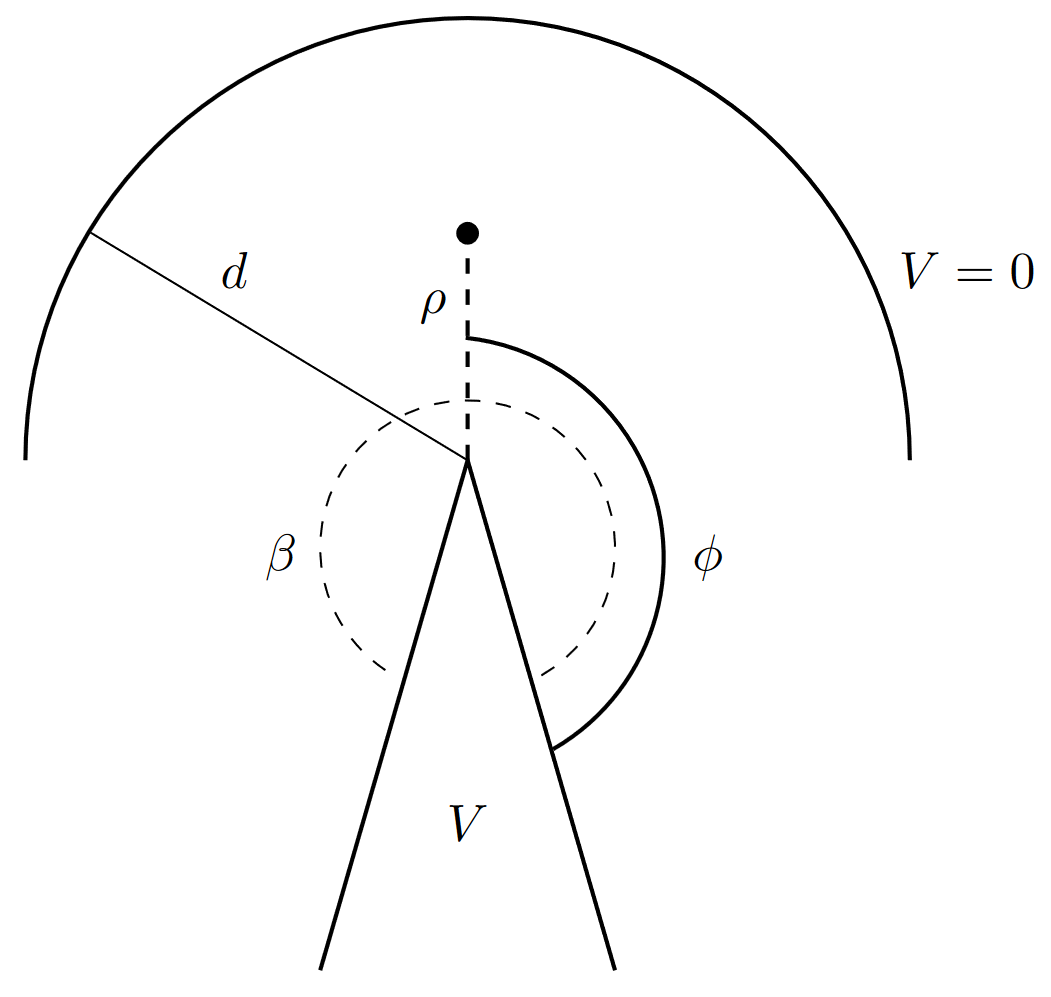

In [17]:
##Import required libraries (code by Jesse Kinder and FEM on Colab project):

try:
    # Import gmsh library for generating meshes.
    import gmsh
except ImportError:
    # If it is not available, install it.  Then import it.
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

try:
    # Import FEniCSx libraries for finite element analysis.
    import dolfinx
except ImportError:
    # If they are not found, install them.  Then import them.
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

try:
    # Import multiphenicsx, mainly for plotting.
    import multiphenicsx
except ImportError:
    # If they are not found, install them.
    !pip3 install "multiphenicsx@git+https://github.com/multiphenics/multiphenicsx.git@8b97b4e"
    import multiphenicsx

# Import the rest of what we need.
import dolfinx.fem
import dolfinx.io
import gmsh
import mpi4py.MPI
import numpy as np
import petsc4py.PETSc
import ufl
import multiphenicsx.fem
import multiphenicsx.io

In [18]:
##Code by Jordan Harris-Toovy, OIT Fall term, 2022

##Setup parametric variables and geometry:

#Radius of the semi-circular "tip" of the cathode
rad_circ = 1

#Distance from the base of the semicircle to the anode
dist_base = 5

#Distance from the center of the base of the semicircle to the side boundaries
dist_side = 5

#Distance from the base of the semicircle to lower boundary
dist_low = 5

#Angle between the vertical and walls of the main cathode
ang_wedge = (3.141592653589793/180) * 30

#Anode-cathode potential difference
pot_diff = 10

#Conductor permittivity
permi_cond = 1

#Background permittivity
permi_back = 1

#Grid spacing
grid_space = 0.1

#Number of dimensions
DIMS = 2

In [19]:
##Create gmsh system:

gmsh.initialize()
gmsh.model.add("mesh")

##Define geometry:

#Cathode tip semicircle points & curve (center of model)
pt_ori = gmsh.model.geo.addPoint(0, 0, 0, grid_space)
pt_arc0 = gmsh.model.geo.addPoint(-rad_circ, 0,0, grid_space)
pt_arc1 = gmsh.model.geo.addPoint(0, rad_circ, 0, grid_space)
pt_arc2 = gmsh.model.geo.addPoint(rad_circ, 0, 0, grid_space)

#Due to open arc not being able to have pi or greater angles in gmsh, the semicircle is made of two pi/2 arcs
cont_arc0 = gmsh.model.geo.addCircleArc(pt_arc0, pt_ori, pt_arc1)
cont_arc1 = gmsh.model.geo.addCircleArc(pt_arc1, pt_ori, pt_arc2)

#Top boundary (anode) points & line
pt_top0 = gmsh.model.geo.addPoint(-dist_side, dist_base, 0, grid_space)
pt_top1 = gmsh.model.geo.addPoint(dist_side, dist_base, 0, grid_space)
cont_top = gmsh.model.geo.addLine(pt_top0, pt_top1)

#Side boundarie's points & lines
pt_side0 = gmsh.model.geo.addPoint(-dist_side, -dist_low, 0, grid_space)
pt_side1 = gmsh.model.geo.addPoint(dist_side, -dist_low, 0, grid_space)
cont_side0 = gmsh.model.geo.addLine(pt_top0, pt_side0)
cont_side1 = gmsh.model.geo.addLine(pt_top1, pt_side1)

#Main cathode body points & lines
pt_bot0 = gmsh.model.geo.addPoint((-1.0 * dist_low * np.tan(ang_wedge)), -dist_low, 0, grid_space)
pt_bot1 = gmsh.model.geo.addPoint((dist_low * np.tan(ang_wedge)), -dist_low, 0, grid_space)
cont_cath0 = gmsh.model.geo.addLine(pt_arc0, pt_bot0)
cont_cath1 = gmsh.model.geo.addLine(pt_arc2, pt_bot1)
cont_cath2 = gmsh.model.geo.addLine(pt_bot0, pt_bot1)

#Remaining bottom segments
cont_bot0 = gmsh.model.geo.addLine(pt_side0, pt_bot0)
cont_bot1 = gmsh.model.geo.addLine(pt_side1, pt_bot1)

#Define the central cavity
cont_cav = gmsh.model.geo.addCurveLoops([cont_arc0, cont_arc1, cont_cath1, cont_bot1, cont_side1, cont_top, cont_side0, cont_bot0, cont_cath0])
surf_cav = gmsh.model.geo.addPlaneSurface(cont_cav)

#Apply new geometry
gmsh.model.geo.synchronize()

In [20]:
##Setup groups and assign properties

#Cathode contours as physical groups 1-4
gmsh.model.addPhysicalGroup(1, [cont_cath0], 1)
gmsh.model.addPhysicalGroup(1, [cont_arc0], 2)
gmsh.model.addPhysicalGroup(1, [cont_arc1], 3)
gmsh.model.addPhysicalGroup(1, [cont_cath1], 4)

#Anode line as physical group 5
gmsh.model.addPhysicalGroup(1, [cont_top], 5)

#Sidewall contours as physical groups 6-9
gmsh.model.addPhysicalGroup(1, [cont_side0], 6)
gmsh.model.addPhysicalGroup(1, [cont_bot0], 7)
gmsh.model.addPhysicalGroup(1, [cont_side1], 8)
gmsh.model.addPhysicalGroup(1, [cont_bot1], 9)


#Setup domain in the central cavity surface as group 10
gmsh.model.addPhysicalGroup(DIMS, [surf_cav], 10)

##Create mesh
gmsh.model.mesh.generate(DIMS)

#Export mesh for external viewing (optional)
gmsh.write("system_mesh.msh")

##Create FEniCSx objects from gmsh model
FE_mesh, FE_subdoms, FE_bounds = dolfinx.io.gmshio.model_to_mesh(gmsh.model, comm=mpi4py.MPI.COMM_WORLD, rank=0, gdim=DIMS)

#Finalize and exit gmsh system
gmsh.finalize()

In [21]:
##Rename FEniCSx object groups
FE_cathode1 = FE_bounds.indices[FE_bounds.values == 1]
FE_cathode2 = FE_bounds.indices[FE_bounds.values == 2]
FE_cathode3 = FE_bounds.indices[FE_bounds.values == 3]
FE_cathode4 = FE_bounds.indices[FE_bounds.values == 4]

FE_anode = FE_bounds.indices[FE_bounds.values == 5]

FE_swall1 = FE_bounds.indices[FE_bounds.values == 6]
FE_swall2 = FE_bounds.indices[FE_bounds.values == 7]
FE_swall3 = FE_bounds.indices[FE_bounds.values == 8]
FE_swall4 = FE_bounds.indices[FE_bounds.values == 9]

FE_cavity = FE_bounds.indices[FE_bounds.values == 10]

##Plot the resultant geometric objects

#Whole mesh (optional)
#multiphenicsx.io.plot_mesh(FE_mesh)

#Subdomains (optional)
#multiphenicsx.io.plot_mesh_tags(FE_subdoms)

#Boundaries (optional)
#multiphenicsx.io.plot_mesh_tags(FE_bounds)

In [22]:
#Define trial & test functions
FE_TTSpace = dolfinx.fem.FunctionSpace(FE_mesh, ("Lagrange", 2))
FE_trial = ufl.TrialFunction(FE_TTSpace)
FE_test = ufl.TestFunction(FE_TTSpace)

#Create FEM function
FE_funct = dolfinx.fem.Function(FE_TTSpace)

#Designate the domain
FE_domain = FE_subdoms.indices[FE_subdoms.values == 1]

#Set up boundaries
FE_cathode_b1 = dolfinx.fem.locate_dofs_topological(FE_TTSpace, FE_bounds.dim, FE_cathode1)
FE_cathode_b2 = dolfinx.fem.locate_dofs_topological(FE_TTSpace, FE_bounds.dim, FE_cathode2)
FE_cathode_b3 = dolfinx.fem.locate_dofs_topological(FE_TTSpace, FE_bounds.dim, FE_cathode3)
FE_cathode_b4 = dolfinx.fem.locate_dofs_topological(FE_TTSpace, FE_bounds.dim, FE_cathode4)

FE_anode_b = dolfinx.fem.locate_dofs_topological(FE_TTSpace, FE_bounds.dim, FE_anode)

FE_swall_b1 = dolfinx.fem.locate_dofs_topological(FE_TTSpace, FE_bounds.dim, FE_swall1)
FE_swall_b2 = dolfinx.fem.locate_dofs_topological(FE_TTSpace, FE_bounds.dim, FE_swall2)
FE_swall_b3 = dolfinx.fem.locate_dofs_topological(FE_TTSpace, FE_bounds.dim, FE_swall3)
FE_swall_b4 = dolfinx.fem.locate_dofs_topological(FE_TTSpace, FE_bounds.dim, FE_swall4)

#Define potentials for essential boundary conditions
FE_anode_v = dolfinx.fem.Constant(FE_mesh, petsc4py.PETSc.ScalarType(0.0))
FE_e_bound = [dolfinx.fem.dirichletbc(FE_anode_v, FE_anode_b, FE_TTSpace)]

FE_cathode_v = dolfinx.fem.Constant(FE_mesh, petsc4py.PETSc.ScalarType(-1.0*pot_diff))
FE_e_bound += [dolfinx.fem.dirichletbc(FE_cathode_v, FE_cathode_b1, FE_TTSpace)]
FE_e_bound += [dolfinx.fem.dirichletbc(FE_cathode_v, FE_cathode_b2, FE_TTSpace)]
FE_e_bound += [dolfinx.fem.dirichletbc(FE_cathode_v, FE_cathode_b3, FE_TTSpace)]
FE_e_bound += [dolfinx.fem.dirichletbc(FE_cathode_v, FE_cathode_b4, FE_TTSpace)]

In [23]:
#Laplace's equation (left side)
LE_left = ufl.inner(ufl.grad(FE_trial), ufl.grad(FE_test)) * ufl.dx

#Laplace's equation (right side)
LE_right = (dolfinx.fem.Constant(FE_mesh, petsc4py.PETSc.ScalarType(0.0))) * FE_test * ufl.dx

#Combine the parts of Laplace's equation into one object & solve
FEA_system = dolfinx.fem.petsc.LinearProblem(LE_left, LE_right, FE_e_bound, u=FE_funct)
FEA_system.solve()

#Misc fixes
FE_funct.vector.ghostUpdate(addv=petsc4py.PETSc.InsertMode.INSERT, mode=petsc4py.PETSc.ScatterMode.FORWARD)

In [24]:
#Display the solution of Laplace's equation
multiphenicsx.io.plot_scalar_field(FE_funct, "Potential", warp_factor=1)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [27]:
#Setup a vector-space and compute the gradient of the potential, combine via interpolation
FEA_vect_space = dolfinx.fem.VectorFunctionSpace(FE_mesh, ("Lagrange", 2))
FEA_e_field = dolfinx.fem.Function(FEA_vect_space)
FEA_ngrad_pot = dolfinx.fem.Expression(ufl.as_vector((-FE_funct.dx(0), -FE_funct.dx(1))), FEA_vect_space.element.interpolation_points())
FEA_e_field.interpolate(FEA_ngrad_pot)

#Plot the electric field
multiphenicsx.io.plot_vector_field(FEA_e_field,name="Electric Field", glyph_factor=0.1)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…